In [1]:
import sys
import os

# Get the absolute path to the root directory where UQ_toolbox.py is located
root_dir = os.path.abspath(os.path.join(os.path.dirname('medMNIST'), '..'))
sys.path.append(root_dir)

In [2]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torchvision.transforms as transforms
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, accuracy_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import UQ_toolbox as uq
import pickle as pkl
import pandas as pd
import umap.umap_ as umap
from utils import train_resnet as tr

In [3]:
def load_models(flag):

    # Load organAMNIST dataset
    data_flag = flag
    info = INFO[data_flag]
    num_classes = len(info['label'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Load saved models
    models = []
    for i in range(5):
        # Initialize the model
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
        if num_classes == 2:
            model.fc = nn.Linear(model.fc.in_features, 1)  # Output 1 value for binary classification
        else:
            model.fc = nn.Linear(model.fc.in_features, num_classes)  # Output logits for each class
        
        # Load the state dictionary
        state_dict = torch.load(f'resnet18_{flag}{i}.pt')

        # Remove the 'model.' prefix from the state_dict keys if necessary
        state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}

        # Load the modified state dictionary into the model
        model.load_state_dict(state_dict)
        model = model.to(device)
        model.eval()
        models.append(model)
    return models

def load_datasets(flag, transform):
    transform=transform
    
    # Load organAMNIST dataset
    data_flag = flag
    download = True
    info = INFO[data_flag]
    task_type = info['task']  # Determine the task type (binary-class or multi-class)
    DataClass = getattr(medmnist, info['python_class'])


    test_dataset = DataClass(split='test', download=download, transform=transform)
    train_dataset = DataClass(split='train', download=download, transform=transform)
    val_dataset = DataClass(split='val', download=download, transform=transform)

    # Combine train_dataset and val_dataset
    combined_train_dataset = ConcatDataset([train_dataset, val_dataset])

    # Set the random seed for reproducibility
    torch.manual_seed(42)

    # Calculate the sizes for training and calibration datasets
    train_size = int(0.8 * len(combined_train_dataset))
    calibration_size = len(combined_train_dataset) - train_size

    # Split the combined_train_dataset into training and calibration datasets
    train_dataset, calibration_dataset = random_split(combined_train_dataset, [train_size, calibration_size])

    print(f'Training dataset size: {len(train_dataset)}')
    print(f'Calibration dataset size: {len(calibration_dataset)}')

    return train_dataset, calibration_dataset, test_dataset, task_type

def test_eval(test_loader, device, models, data_flag):
    info = INFO[data_flag]
    task_type = info['task']  # Determine the task type (binary-class or multi-class)
    num_classes = len(info['label'])  # Number of classes

    # Perform inference on the test set
    y_true = []
    y_scores = []
    y_raw_digits = []
    indiv_scores = [[] for _ in range(len(models))]
   
    for m in models:
        m.eval()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = [model(data) for model in models]

            # Average the outputs for ensemble prediction
            avg_output = torch.mean(torch.stack(outputs), dim=0)
            y_true.extend(target.cpu().numpy().flatten())
            if task_type == 'binary-class':
                avg_output_sig = F.sigmoid(avg_output)
                y_scores.extend(avg_output_sig.cpu().numpy().flatten())
                y_raw_digits.extend(avg_output.cpu().numpy().flatten())
            else:
                y_scores.extend(avg_output.cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_scores_raw_digits = np.array(y_raw_digits)
    
    if task_type == 'binary-class':
        y_pred = (y_scores > 0.5).astype(int)
        auc = roc_auc_score(y_true, y_scores)
    else:
        y_pred = np.argmax(y_scores, axis=1)
        # Calculate metrics
        auc = roc_auc_score(y_true, apply_softmax(y_scores), multi_class='ovr')
    acc = accuracy_score(y_true, y_pred)
    print(f'Ensemble AUC: {auc:.3f}, Ensemble Accuracy: {acc:.3f}')

    # Generate the confusion matrix
    if task_type == 'binary-class':
        cm = confusion_matrix(y_true, y_pred)
    else:
        cm = confusion_matrix(y_true, y_scores.argmax(axis=1))

   
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute balanced accuracy
    if task_type == 'binary-class':
        balanced_acc = balanced_accuracy_score(y_true, y_pred)
    else:
        balanced_acc = balanced_accuracy_score(y_true, y_scores.argmax(axis=1))
    print(f'Balanced Accuracy: {balanced_acc:.3f}')

    # Compute sensitivity (recall)
    if task_type == 'binary-class':
        sensitivity = recall_score(y_true, y_pred, average='binary')
    else:
        sensitivity = recall_score(y_true, y_scores.argmax(axis=1), average='macro')
    print(f'Sensitivity: {sensitivity:.3f}')

    # Compute specificity
    specificities = []
    for i in range(num_classes):
        if task_type == 'binary-class':
            cm = confusion_matrix(y_true, y_pred)
        else:
            cm = confusion_matrix(y_true, y_scores.argmax(axis=1))
        FP = np.sum(cm[:, i]) - cm[i, i]  # False Positives
        TN = np.sum(cm) - (np.sum(cm[i, :]) + FP)  # True Negatives
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 1.0
        specificities.append(specificity)

    macro_specificity = np.mean(specificities)
    print(f"Specificity: {macro_specificity:.4f}")
    return y_true, y_scores, y_scores_raw_digits

def apply_softmax(y):
    y_scores = np.array(F.softmax(torch.tensor(y), dim=1))
    return y_scores

In [4]:
def train_val_loaders(train_dataset, size):
    # Create stratified K-fold cross-validator
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Get the labels for stratification
    labels = [label for _, label in train_dataset]

    # Create a list to store the new dataloaders
    train_loaders = []
    val_loaders = []

    for train_index, val_index in skf.split(np.zeros(len(labels)), labels):
        train_subset = torch.utils.data.Subset(train_dataset, train_index)
        val_subset = torch.utils.data.Subset(train_dataset, val_index)
        
        train_loader = DataLoader(dataset=train_subset, batch_size=size, shuffle=True, drop_last=True)
        val_loader = DataLoader(dataset=val_subset, batch_size=size, shuffle=True, drop_last=True)
        
        train_loaders.append(train_loader)
        val_loaders.append(val_loader)
    return train_loaders, val_loaders

In [5]:
def find_best_threshold_and_compute_metrics(values, correct_predictions, optimization_metric='balanced_accuracy'):
    """
    Find the best threshold and compute metrics.

    Args:
        values (numpy.ndarray): UQ values.
        correct_predictions (list): Indices of correct predictions.
        optimization_metric (str): Metric to optimize ('balanced_accuracy', 'sensitivity', 'specificity').

    Returns:
        None
    """
    # Function to compute metrics
    def compute_metrics(uq_values, labels, threshold):
        predictions = (uq_values <= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        balanced_acc = balanced_accuracy_score(labels, predictions)
        return tn, fp, fn, tp, specificity, sensitivity, balanced_acc

    # Update the function to handle ties in specificity or sensitivity
    def find_optimal_threshold(uq_values, labels, metric):
        thresholds = np.linspace(min(uq_values), max(uq_values), 1000)
        best_threshold = thresholds[0]
        best_metric_value = 0
        best_secondary_metric_value = 0

        for threshold in thresholds:
            _, _, _, _, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)

            if metric == 'balanced_accuracy' and balanced_acc > best_metric_value:
                best_metric_value = balanced_acc
                best_threshold = threshold
            elif metric == 'sensitivity':
                if sensitivity > best_metric_value or (sensitivity == best_metric_value and specificity > best_secondary_metric_value):
                    best_metric_value = sensitivity
                    best_secondary_metric_value = specificity
                    best_threshold = threshold
            elif metric == 'specificity':
                if specificity > best_metric_value or (specificity == best_metric_value and sensitivity > best_secondary_metric_value):
                    best_metric_value = specificity
                    best_secondary_metric_value = sensitivity
                    best_threshold = threshold

        return best_threshold

    # Find the optimal threshold
    labels = np.array([1 if i in correct_predictions else 0 for i in range(len(values))])
    optimal_threshold = find_optimal_threshold(values, labels, optimization_metric)

    # Compute the confusion matrix using the optimal threshold
    predictions = (values <= optimal_threshold).astype(int)
    cm = confusion_matrix(labels, predictions)

    # Display the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 36}, xticklabels=['Failure', 'Success'], yticklabels=['Failure', 'Success'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print the optimal threshold and metrics
    _, _, _, _, specificity, sensitivity, balanced_acc = compute_metrics(values, labels, optimal_threshold)
    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Balanced Accuracy: {balanced_acc}")
    print(f"Specificity: {specificity}")
    print(f"Sensitivity: {sensitivity}")

In [ ]:
def computeMSR(y_prob, y_true, task_type, calibration_needed=False, method_calibration=None, display_calibration_curve=False, y_scores_calibration=None, y_true_calibration=None):
    if calibration_needed:
            # Perform post-hoc calibration using the calibration dataset
            calibrated_scores, calibration_model = uq.posthoc_calibration(y_scores_calibration, y_true_calibration, method_calibration)
            if method_calibration == 'temperature':
                logits_tensor = torch.from_numpy(y_prob).float()
                if logits_tensor.ndim == 1:
                    logits_tensor = logits_tensor.unsqueeze(1)
                logits_test_scaled = calibration_model(logits_tensor)

                if logits_test_scaled.ndim == 1 or logits_test_scaled.shape[1] == 1:
                    # Binary case → use sigmoid
                    calibrated_test_scores = torch.sigmoid(logits_test_scaled).detach().numpy()
                else:
                    # Multiclass → use softmax
                    calibrated_test_scores = torch.nn.functional.softmax(logits_test_scaled, dim=1).detach().numpy()

            else:
                calibrated_test_scores = calibration_model.predict(y_prob.reshape(-1, 1))
            metric = uq.distance_to_hard_labels_computation(calibrated_test_scores)
            if display_calibration_curve:
                uq.model_calibration_plot(y_true, calibrated_test_scores)
    else:
        metric = uq.distance_to_hard_labels_computation(y_prob)
        if display_calibration_curve:
            uq.model_calibration_plot(y_true, y_prob)
    
    return metric

def compute_ensembling():
    
def computeKNNshap(models, train_loaders, test_loader, device, num_classes=None, latent_spaces=None, shap_values_folds=None, labels_folds=None, shap=True):
    if shap:
        mean_shap_importances = []
        for fold, (shap_values, labels) in enumerate(zip(shap_values_folds, labels_folds)):
            mean_shap_fold = uq.compute_mean_shap_values(shap_values, fold, labels, 50)
            mean_shap_importances.append(mean_shap_fold)

        latent_spaces_df = []
        for fold, latent_space in enumerate(latent_spaces):
            num_samples, num_features = latent_space.shape
            latent_space_df = pd.DataFrame(
                latent_space,
                columns=[f"Feature_{i}" for i in range(num_features)]
            )
            latent_spaces_df.append(latent_space_df)

        plt.close('all')
        successes_folds = []
        knn_distances_folds = []

        for fold in range(5):
            knn_distances_all, successes_all = uq.compute_knn_distances_to_train_data(models[fold], train_loaders[fold], test_loader, models[fold].avgpool, device, latent_spaces_df[fold], mean_shap_importances[fold], num_classes)
            knn_distances_folds.append(knn_distances_all)
            successes_folds.append(successes_all)
        
        # Calculate the mean of the lists inside knn_distances_folds
        metric = np.mean(knn_distances_folds, axis=0)

    else:
        knn_distances_all = []
        for fold in range(5):
            latent_space_training, _, _, _ = uq.extract_latent_space_and_compute_shap_importance(
                model=models[fold],
                data_loader=train_loaders[fold],
                device=device,
                layer_to_be_hooked=models[fold].avgpool,
                importance=False
            )
            
            latent_space_test, _, _, _ = uq.extract_latent_space_and_compute_shap_importance(
                model=models[fold],
                data_loader=test_loader,
                device=device,
                layer_to_be_hooked=models[fold].avgpool,
                importance=False
            )
            
            train_latent_space = pd.DataFrame(latent_space_training)
            test_latent_space = pd.DataFrame(latent_space_test)
                
            # Print the initial number of dimensions
            print(f"Initial number of dimensions: {train_latent_space.shape[1]}")
                
            scaler = StandardScaler()
            train_latent_space_standardized = scaler.fit_transform(train_latent_space)
            
            pca = PCA(n_components=0.9)
            train_latent_space_pca = pca.fit_transform(train_latent_space_standardized)
            
            # Print the number of dimensions after PCA
            print(f"Number of dimensions after PCA: {train_latent_space_pca.shape[1]}")
            
            test_latent_space_standardized = scaler.transform(test_latent_space)
            test_latent_space_pca = pca.transform(test_latent_space_standardized)
            
            knn = NearestNeighbors(n_neighbors=5)
            knn.fit(train_latent_space_pca)
            distances, _ = knn.kneighbors(test_latent_space_pca)
            
            average_distances = distances.mean(axis=1)
            
            knn_distances_all.append(average_distances)
            # Calculate the mean of the lists inside knn_distances_folds
            metric = np.mean(knn_distances_all, axis=0)

    return metric

def computeTTA(aug_type, models, test_loader, device, correct_predictions_calibration=None, incorrect_predictions_calibration=None):
    if aug_type == 'randaugment':
        transforms = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.RandAugment(2, 9),
                        transforms.PILToTensor(),
                        transforms.ConvertImageDtype(torch.float)
                    ])
        metric, global_preds = uq.TTA(transforms, models, test_loader, device, nb_augmentations=5, nb_channels=3, softmax_application=True, usingBetterRandAugment=False)
    elif aug_type == 'crops_flips':
        transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(size=20, scale=(0.8, 1.0)),  # Random crop with resizing
            transforms.RandomHorizontalFlip(p=0.5),                   # Random horizontal flip
            transforms.RandomRotation(degrees=180),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])
        metric, global_preds = uq.TTA(transforms, models, test_loader, device, nb_augmentations=5, nb_channels=3, softmax_application=True, usingBetterRandAugment=False)
        
    elif aug_type == 'GPS':
        best_aug = uq.perform_greedy_policy_search('savedpolicies', correct_predictions_calibration, incorrect_predictions_calibration, num_workers=90, max_iterations=30, num_searches=30, top_k=5, plot=True)
        n, m, transforms = uq.extract_gps_augmentations_info(best_aug)
        metric, global_preds_GPS = uq.TTA(transforms, models, test_loader, device, usingBetterRandAugment=True, n=n, m=m, nb_channels=3, image_size=28, batch_norm=True, softmax_application=True)
    
    return metric

In [7]:
def display_UQ_results(metric, correct_predictions, incorrect_predictions, y_axis_title, title, optim_metric, swarmplot=False):

    uq.UQ_method_plot([metric[k] for k in correct_predictions], [metric[j] for j in incorrect_predictions], y_axis_title, title, swarmplot)
    find_best_threshold_and_compute_metrics(metric, correct_predictions, optim_metric)
    fpr, tpr, auc = uq.roc_curve_UQ_method_computation([metric[k] for k in correct_predictions], [metric[j] for j in incorrect_predictions])
    print(auc)

In [8]:
flag = 'organamnist'

In [9]:
transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean=[.5], std=[.5]),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    ])

In [10]:
models = load_models(flag)

In [11]:
train_dataset, calibration_dataset, test_dataset, task_type = load_datasets(flag, transform)
train_loaders, val_loaders = train_val_loaders(train_dataset, size=32)
test_loader=DataLoader(test_dataset, batch_size=32, shuffle=False)
calibration_loader=DataLoader(calibration_dataset, batch_size=32, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

Training dataset size: 32841
Calibration dataset size: 8211


/tmp/ipykernel_234290/72446316.py:153: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 0.997, Ensemble Accuracy: 0.936


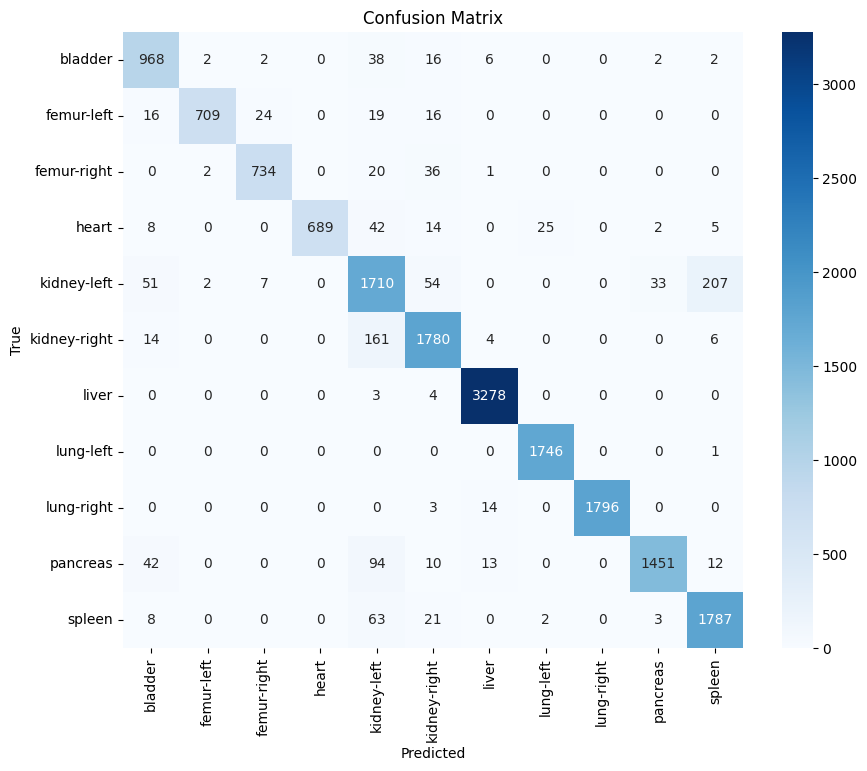

Balanced Accuracy: 0.928
Sensitivity: 0.928
Specificity: 0.9935


/tmp/ipykernel_234290/72446316.py:153: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


Ensemble AUC: 1.000, Ensemble Accuracy: 0.998


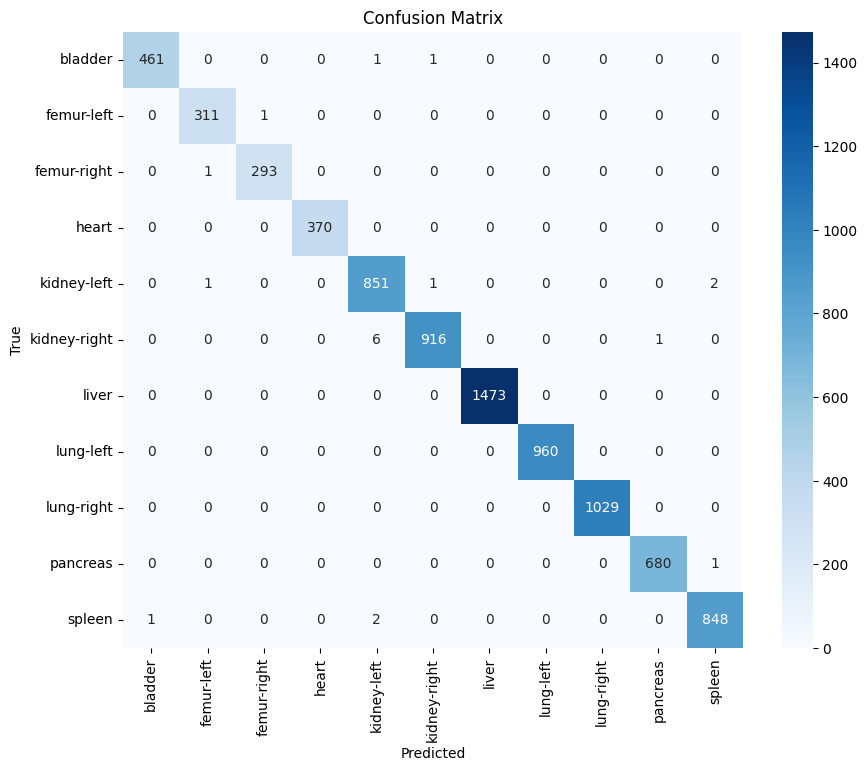

Balanced Accuracy: 0.997
Sensitivity: 0.997
Specificity: 0.9998


/tmp/ipykernel_234290/72446316.py:153: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_scores = np.array(F.softmax(torch.tensor(y), dim=1))


In [12]:
y_true, y_scores, digits = test_eval(test_loader, device=device, models=models, data_flag=flag)
y_true_calibration, y_scores_calibration, digits_calib = test_eval(calibration_loader, device=device, models=models, data_flag=flag)

if task_type == 'binary-class':
    y_prob = y_scores
else:
    y_prob = apply_softmax(y_scores)

if task_type == 'binary-class':
    correct_predictions = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] > 0.5) or (y_true[i] == 0 and y_scores[i] <= 0.5)]
    incorrect_predictions = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] <= 0.5) or (y_true[i] == 0 and y_scores[i] > 0.5)]

    correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] > 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] <= 0.5)]
    incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] <= 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] > 0.5)]
else:
    correct_predictions = [i for i in range(len(y_true)) if y_true[i] == np.argmax(y_scores[i])]
    incorrect_predictions = [i for i in range(len(y_true)) if y_true[i] != np.argmax(y_scores[i])]

    correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] == np.argmax(y_scores_calibration[i])]
    incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] != np.argmax(y_scores_calibration[i])]

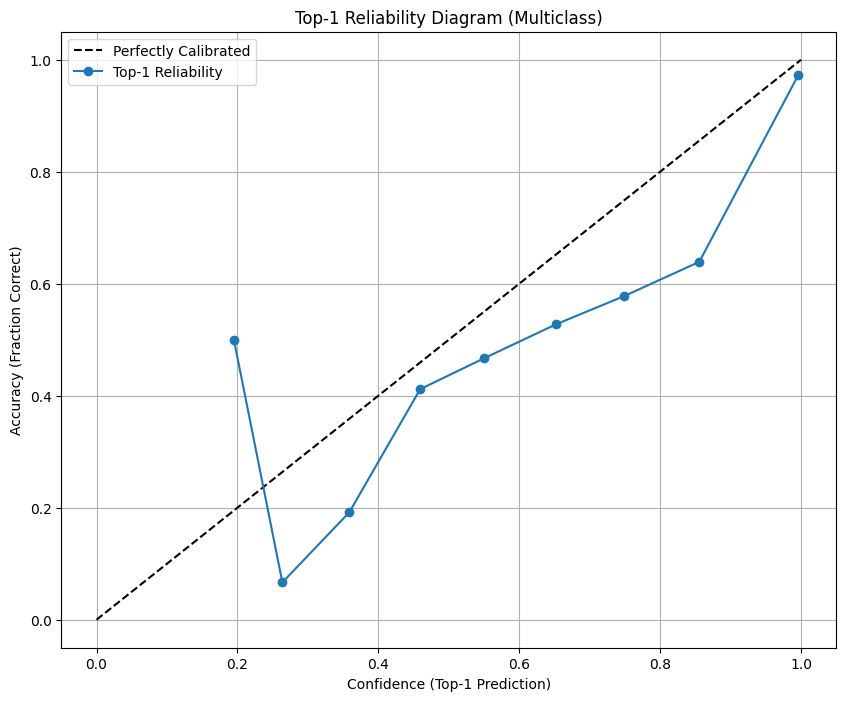

In [13]:
MSR = computeMSR(y_prob, y_true, task_type, calibration_needed=False, display_calibration_curve=True)

Brier Score Loss (temperature): 0.0006


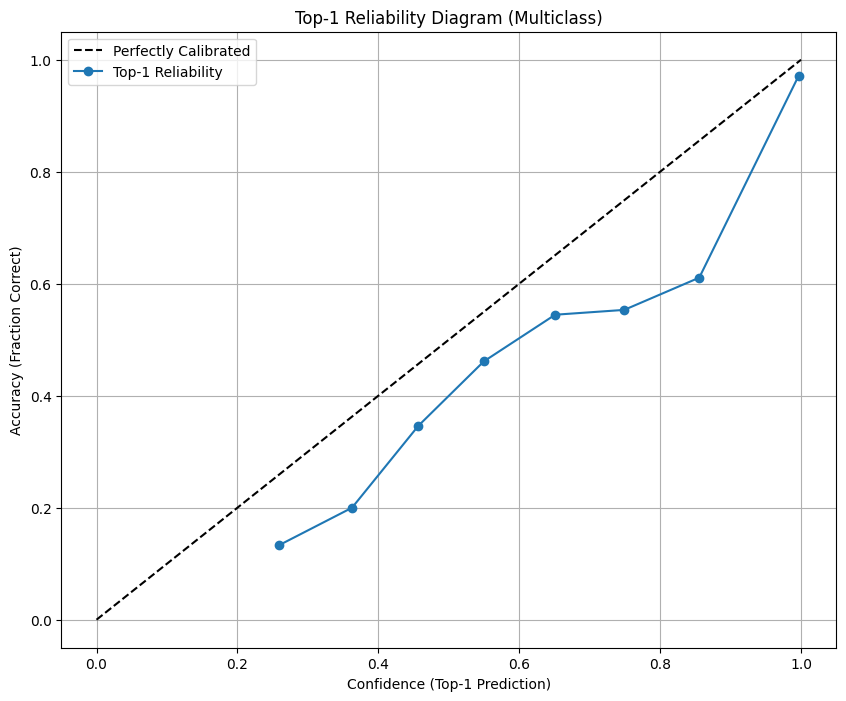

In [14]:
MSR_scaled = computeMSR(y_scores, y_true, task_type, calibration_needed=True, display_calibration_curve=True, method_calibration='temperature', y_scores_calibration=y_scores_calibration, y_true_calibration=y_true_calibration)

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:537: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


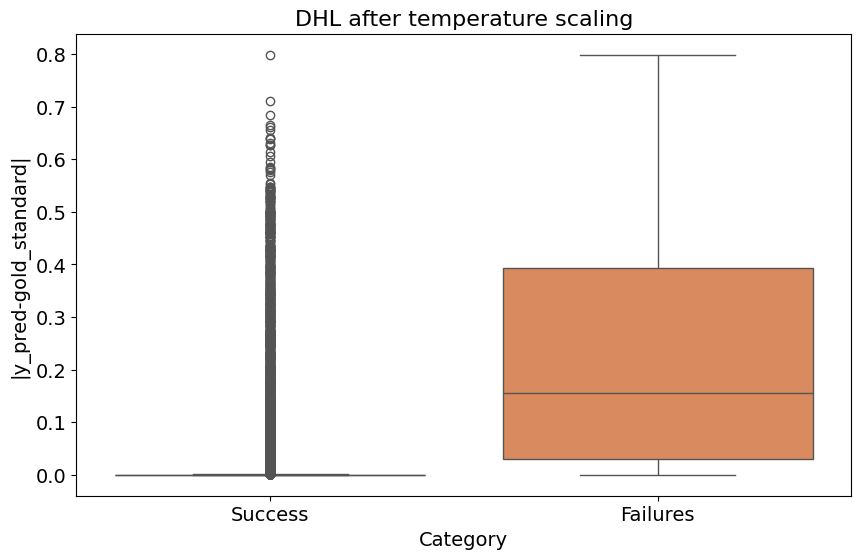

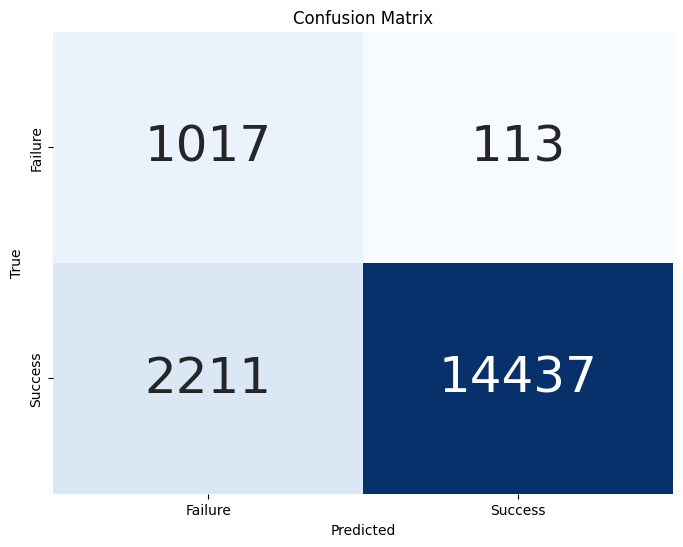

Optimal Threshold: 0.0031996951438486576
Balanced Accuracy: 0.8835956271023546
Specificity: 0.9
Sensitivity: 0.8671912542047093
0.9445163361726197


In [15]:
display_UQ_results(MSR_scaled, correct_predictions, incorrect_predictions, '|y_pred-gold_standard|', 'DHL after temperature scaling', optim_metric='balanced_accuracy', swarmplot=False)

In [15]:
class ClassifierHeadWrapper(nn.Module):
    def __init__(self, model):
        super(ClassifierHeadWrapper, self).__init__()
        self.fc = model.fc  # Replace 'fc2' with the appropriate layer name

    def forward(self, x):
        return self.fc(x)

In [16]:
len(calibration_dataset)

125

In [17]:
models = [model.to(device) for model in models]
latent_spaces = []
shap_values_folds = []
success_folds = []
labels_fold = []
for fold in range(0, 5):
    print('fold n' + str(fold))
    classifier_head = ClassifierHeadWrapper(models[fold]).to(device)
    # Compute SHAP values for the penultimate layer
    shap_values, shap_features, labels, success = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=calibration_loader,
        device=device,
        layer_to_be_hooked=models[fold].avgpool,
        classifierheadwrapper=classifier_head,
        max_background_samples=125
    )
    latent_spaces.append(shap_features)
    shap_values_folds.append(shap_values)
    success_folds.append(success.squeeze() if success.ndim > 1 else success)
    labels_fold.append(labels.squeeze() if labels.ndim > 1 else labels)

fold n0


fold n1
fold n2
fold n3
fold n4


In [18]:
# # Load the SHAP results from the pickle file
# with open('shap_results_calibration_breastmnist.pkl', 'rb') as file:
#     shap_results_calibration = pkl.load(file)

In [19]:
num_classes = 2

In [20]:
mean_knn_distances_shap = computeKNNshap(models, train_loaders, test_loader, device, num_classes, latent_spaces, shap_values_folds, labels_fold, shap=True)

SHAP Feature Importances Computation
Class 0: SHAP Feature Importances
Feature_21     0.088464
Feature_420    0.076799
Feature_454    0.075901
Feature_110    0.075099
Feature_83     0.067258
Feature_448    0.067134
Feature_287    0.062523
Feature_343    0.059734
Feature_81     0.059163
Feature_46     0.058975
Feature_233    0.058443
Feature_72     0.056879
Feature_115    0.056348
Feature_506    0.055782
Feature_109    0.055495
Feature_435    0.053680
Feature_373    0.053413
Feature_93     0.053074
Feature_449    0.053042
Feature_3      0.052626
Feature_36     0.052491
Feature_146    0.052096
Feature_129    0.050538
Feature_242    0.050436
Feature_439    0.049886
Feature_157    0.049511
Feature_488    0.048555
Feature_88     0.048443
Feature_133    0.048112
Feature_481    0.046989
Feature_31     0.046811
Feature_95     0.046800
Feature_249    0.046788
Feature_412    0.046705
Feature_198    0.045849
Feature_156    0.045622
Feature_271    0.045248
Feature_265    0.044923
Feature_393    0.

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:518: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


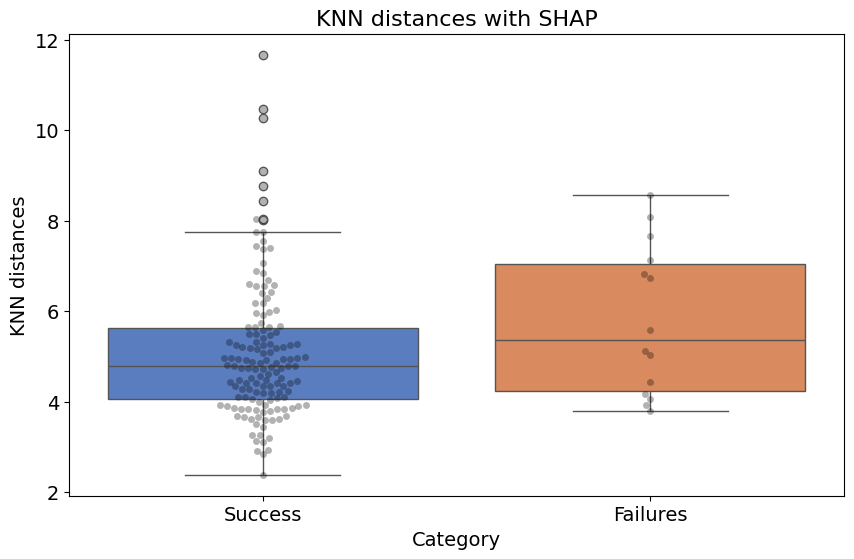

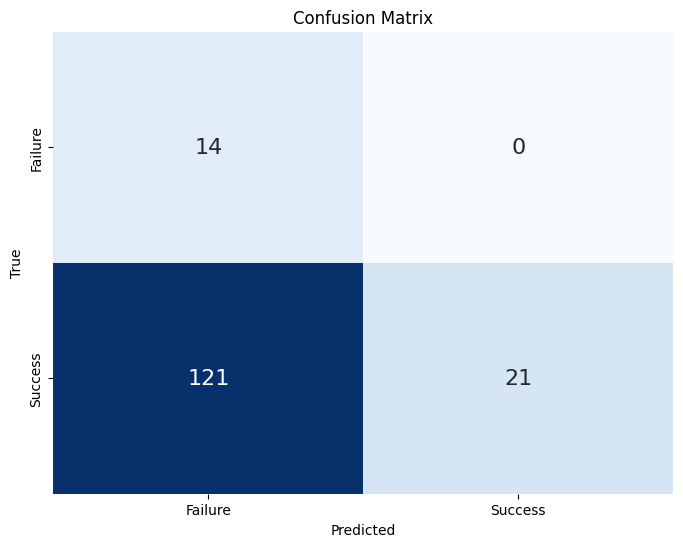

Optimal Threshold: 3.787618607873316
Balanced Accuracy: 0.573943661971831
Specificity: 1.0
Sensitivity: 0.14788732394366197
0.6277665995975856


In [21]:
display_UQ_results(mean_knn_distances_shap, correct_predictions, incorrect_predictions, 'KNN distances', 'KNN distances with SHAP', optim_metric='specificity', swarmplot=True)

0
Initial number of dimensions: 512


/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced dimensions (train): (384, 2)
Reduced dimensions (test): (156, 2)


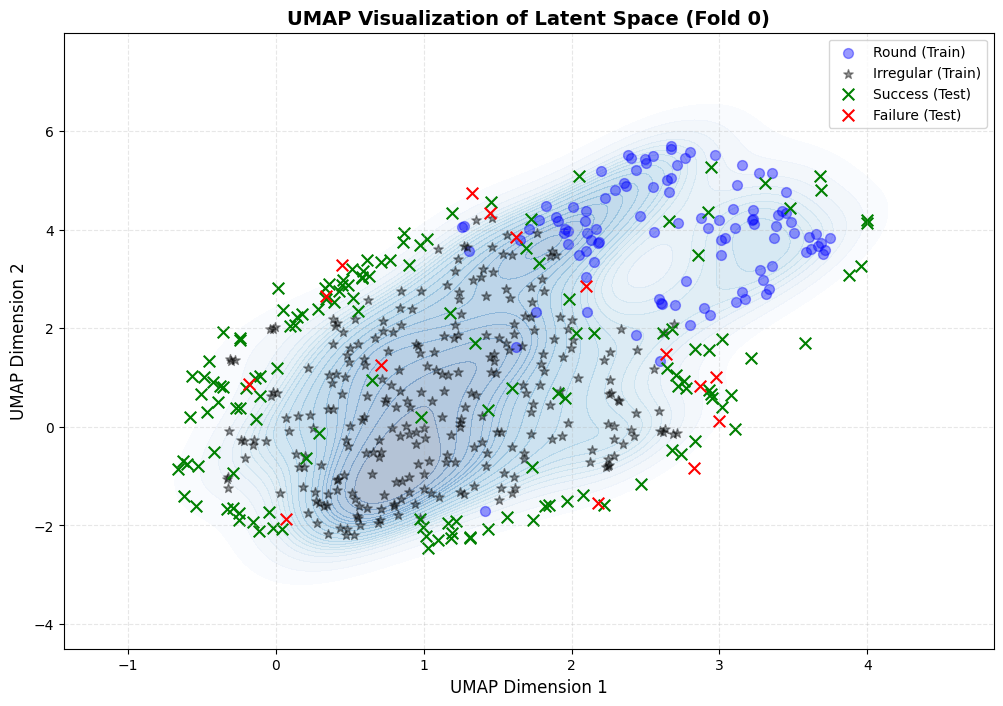

1
Initial number of dimensions: 512


/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced dimensions (train): (384, 2)
Reduced dimensions (test): (156, 2)


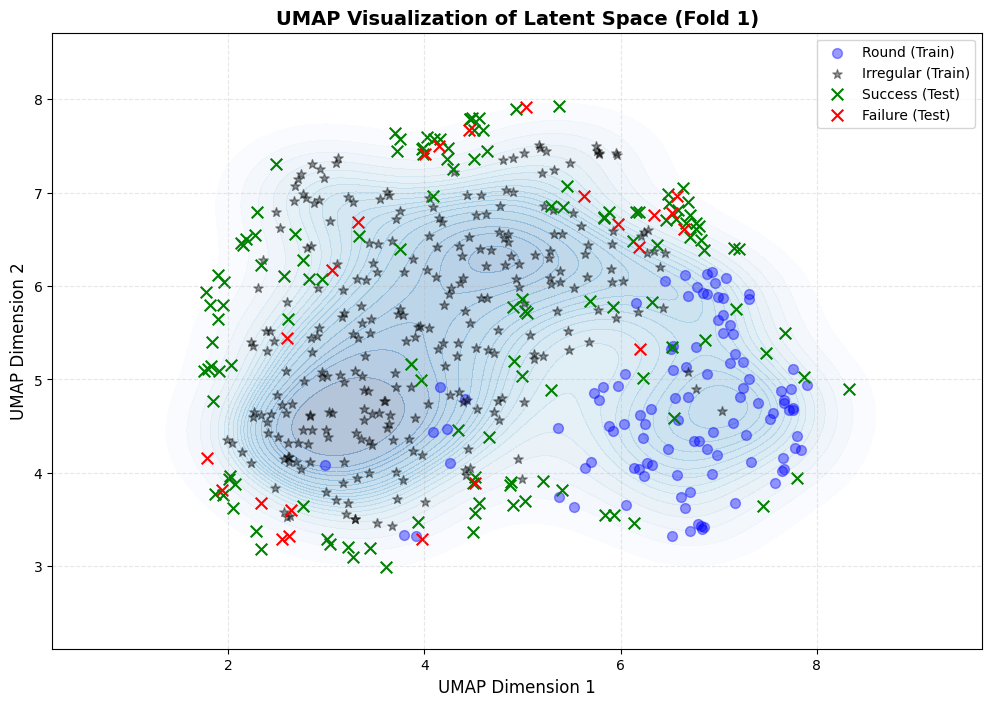

2
Initial number of dimensions: 512


/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced dimensions (train): (384, 2)
Reduced dimensions (test): (156, 2)


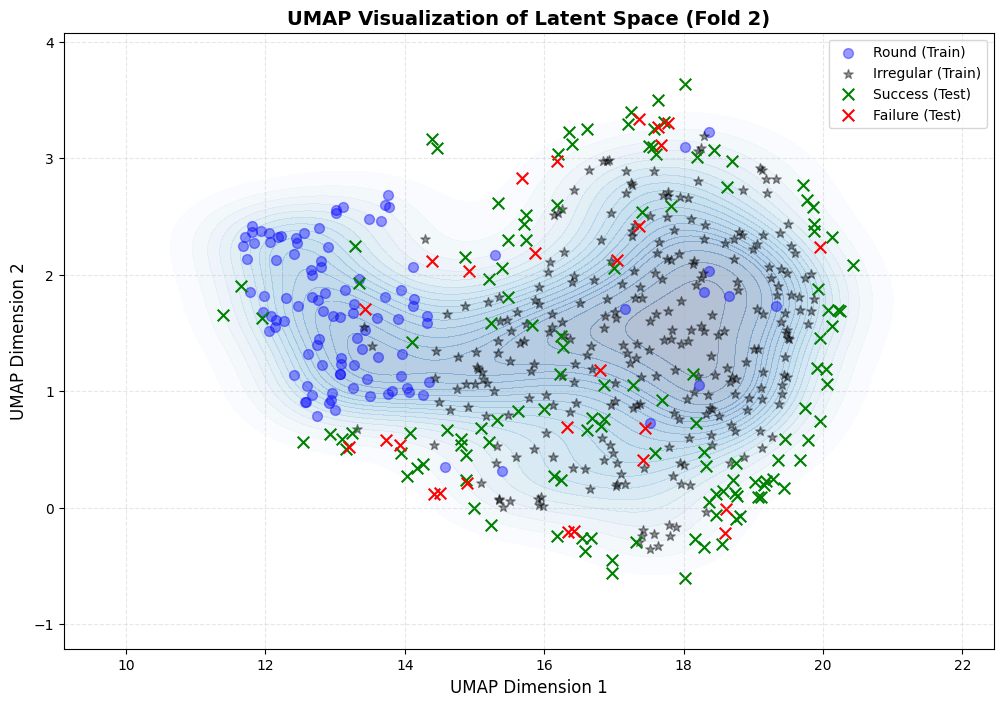

3
Initial number of dimensions: 512


/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced dimensions (train): (384, 2)
Reduced dimensions (test): (156, 2)


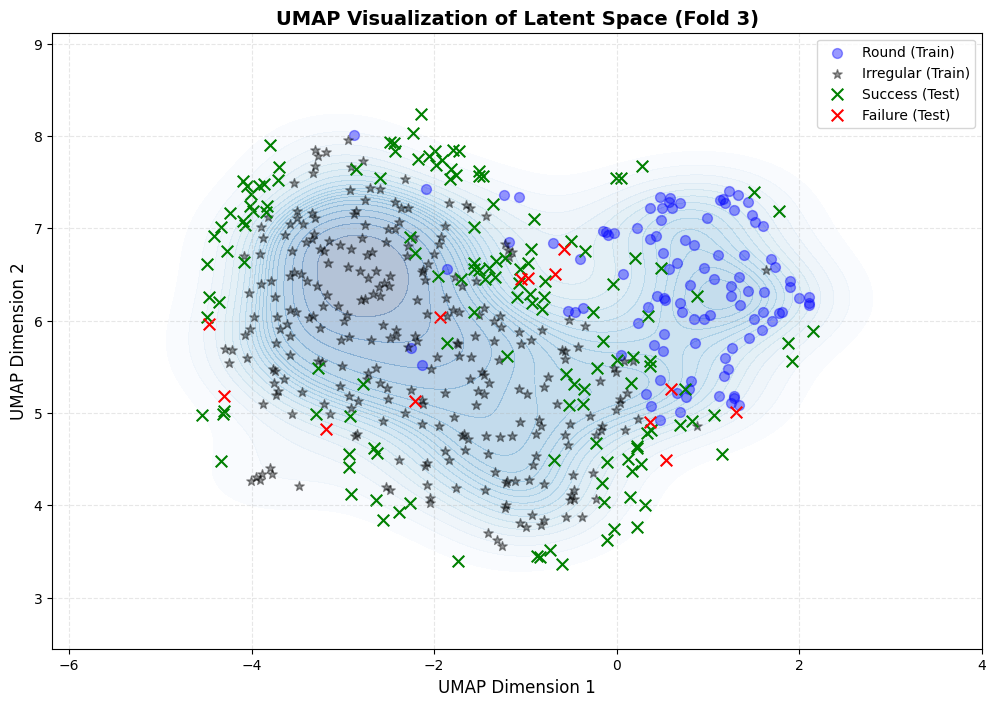

4
Initial number of dimensions: 512


/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Reduced dimensions (train): (384, 2)
Reduced dimensions (test): (156, 2)


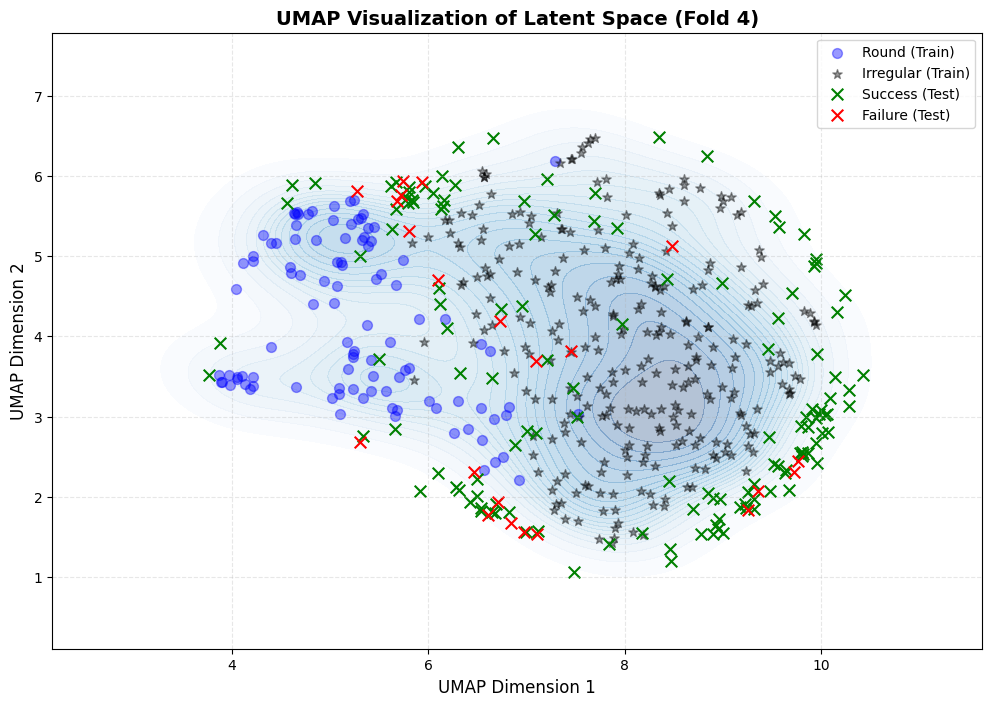

In [23]:
for fold in range(5):
    print(fold)
    latent_space_training, labels_train, flags_train, _ = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=train_loaders[fold],
        device=device,
        layer_to_be_hooked=models[fold].avgpool,
        importance=False
    )
    
    latent_space_test, labels_test, flags_test, _ = uq.extract_latent_space_and_compute_shap_importance(
        model=models[fold],
        data_loader=test_loader,
        device=device,
        layer_to_be_hooked=models[fold].avgpool,
        importance=False
    )
    
    train_latent_space = pd.DataFrame(latent_space_training)
    test_latent_space = pd.DataFrame(latent_space_test)
        
    # Print the initial number of dimensions
    print(f"Initial number of dimensions: {train_latent_space.shape[1]}")
        
    scaler = StandardScaler()
    train_latent_space_standardized = scaler.fit_transform(train_latent_space)
    # Apply UMAP for dimensionality reduction to 2D
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    train_latent_space_umap = umap_reducer.fit_transform(train_latent_space_standardized)
    test_latent_space_umap = umap_reducer.transform(scaler.transform(test_latent_space))

    # Print the reduced dimensions
    print(f"Reduced dimensions (train): {train_latent_space_umap.shape}")
    print(f"Reduced dimensions (test): {test_latent_space_umap.shape}")
    
    uq.visualize_umap_with_labels(train_latent_space_umap, test_latent_space_umap, flags_test, labels_train, fold)

In [ ]:
np.unique(flags_test, return_counts=True)

In [ ]:
mean_knn_distances = computeKNNshap(models, train_loaders, test_loader, device, shap=False)

In [ ]:
display_UQ_results(mean_knn_distances, correct_predictions, incorrect_predictions, 'KNN distances', 'KNN distances', optim_metric='specificity', swarmplot=True)

In [ ]:
uq.UQ_method_plot([stds_TTA[k] for k in correct_predictions], [stds_TTA[j] for j in incorrect_predictions], 'Mean(stds)', 'TTA', swarmplot=False)

In [ ]:
find_best_threshold_and_compute_metrics(stds_TTA, correct_predictions)

In [ ]:
fpr_std_rt, tpr_std_rt, auc_std_rt = uq.roc_curve_UQ_method_computation([stds_RT[k] for k in correct_predictions], [stds_RT[j] for j in incorrect_predictions])
uq.UQ_method_plot([stds_RT[k] for k in correct_predictions], [stds_RT[j] for j in incorrect_predictions], 'Stds', 'TTA', swarmplot=False)

In [ ]:
fpr_std_tta, tpr_std_tta, auc_std_tta = uq.roc_curve_UQ_method_computation([stds_TTA[k] for k in correct_predictions], [stds_TTA[j] for j in incorrect_predictions])
uq.UQ_method_plot([stds_TTA[k] for k in correct_predictions], [stds_TTA[j] for j in incorrect_predictions], 'Stds', 'TTA', swarmplot=False)

In [ ]:
#uq.apply_randaugment_and_store_results(calibration_loader, models, 2, 45, 500, device, folder_name=f'savedpolicies', batch_norm=True, image_size=28, nb_channels=3, softmax_application=True)

In [ ]:
transformations = ['[(9, np.float64(18.993544968225756)), (12, np.float64(-1.372124799393923))]',
 '[(9, np.float64(13.796092578543764)), (13, np.float64(9.650253122391298))]',
 '[(9, np.float64(26.753347976507428)), (4, np.float64(-2.269870568517014))]',
 '[(10, np.float64(1.7976877272614402)), (14, np.float64(-2.253227258808664))]',
 '[(11, np.float64(-7.330877383517148)), (13, np.float64(17.226544341423256))]']
n=2
m=45

In [ ]:
stds_GPS, global_preds_GPS = uq.TTA(transformations, models, test_loader, device, usingBetterRandAugment=True, n=n, m=m, nb_channels=3, image_size=28, batch_norm=True, softmax_application=True)

In [ ]:
fpr_std_gps, tpr_std_gps, auc_std_gps = uq.roc_curve_UQ_method_computation([stds_GPS[k] for k in correct_predictions], [stds_GPS[j] for j in incorrect_predictions])
uq.UQ_method_plot([stds_GPS[k] for k in correct_predictions], [stds_GPS[j] for j in incorrect_predictions], 'Mean(stds)', 'GPS', swarmplot=False)

In [ ]:
find_best_threshold_and_compute_metrics(stds_GPS, correct_predictions)

In [ ]:
auc_std_gps

In [ ]:
best_aug_calibration = uq.perform_greedy_policy_search('savedpolicies_testset', correct_predictions, incorrect_predictions, num_workers=90, max_iterations=30, num_searches=30, top_k=5, plot=True)
n, m, transformations_calibration = uq.extract_gps_augmentations_info(best_aug_calibration)

In [ ]:
transformations_calibration = ['[(13, np.float64(9.826685866454547)), (11, np.float64(-1.9805003878025786))]',
 '[(9, np.float64(1.804627907095039)), (12, np.float64(-1.3265139396701287))]',
 '[(9, np.float64(-21.201456998141612)), (0, np.float64(28.024478487844902))]',
 '[(10, np.float64(-6.385809050023269)), (10, np.float64(12.903347343792575))]',
 '[(11, np.float64(-8.335989058024602)), (13, np.float64(-3.0399266781252194))]']

In [ ]:
stds_GPS_calibration, global_preds_GPS_calibration = uq.TTA(transformations_calibration, models, calibration_loader, device, usingBetterRandAugment=True, n=n, m=m, nb_channels=3, image_size=28, batch_norm=True, softmax_application=True)

In [ ]:
fpr_std_gps_calibration, tpr_std_gps_calibration, auc_std_gps_calibration = uq.roc_curve_UQ_method_computation([stds_GPS_calibration[k] for k in correct_predictions_calibration], [stds_GPS_calibration[j] for j in incorrect_predictions_calibration])
uq.UQ_method_plot([stds_GPS_calibration[k] for k in correct_predictions_calibration], [stds_GPS_calibration[j] for j in incorrect_predictions_calibration], 'Métrique QI', 'Incertitude calculée succès / échecs', swarmplot=False)

In [ ]:
distances = uq.distance_to_hard_labels_computation(y_prob)
distances_calibration = uq.distance_to_hard_labels_computation(y_prob_calibration)

In [ ]:
uq.UQ_method_plot([distances[k] for k in correct_predictions], [distances[j] for j in incorrect_predictions], '1-max(prob)', 'Max Softmax Response', swarmplot=False)

In [ ]:
find_best_threshold_and_compute_metrics(distances, correct_predictions)

In [ ]:
stds = uq.ensembling_stds_computation(indiv_scores)
stds_calibration = uq.ensembling_stds_computation(indiv_scores_calibration)
uq.UQ_method_plot([stds[k] for k in correct_predictions], [stds[j] for j in incorrect_predictions], 'Mean(Stds)', 'Standard deviations ensembling', swarmplot=False)

In [ ]:
find_best_threshold_and_compute_metrics(stds, correct_predictions)

In [ ]:
fpr_distance_to_hard_labels, tpr_distance_to_hard_labels, auc_distance_to_hard_labels = uq.roc_curve_UQ_method_computation([distances[k] for k in correct_predictions], [distances[j] for j in incorrect_predictions])
fpr_stds, tpr_stds, auc_stds = uq.roc_curve_UQ_method_computation([stds[k] for k in correct_predictions], [stds[j] for j in incorrect_predictions])
fpr_std_knn, tpr_std_knn, auc_std_knn = uq.roc_curve_UQ_method_computation([mean_knn_distances_all_features[k] for k in correct_predictions], [mean_knn_distances_all_features[j] for j in incorrect_predictions])
fpr_std_knnshap, tpr_std_knnshap, auc_std_knnshap = uq.roc_curve_UQ_method_computation([mean_knn_distances[k] for k in correct_predictions], [mean_knn_distances[j] for j in incorrect_predictions])
fpr_std_tta, tpr_std_tta, auc_std_tta = uq.roc_curve_UQ_method_computation([stds_TTA[k] for k in correct_predictions], [stds_TTA[j] for j in incorrect_predictions])
fpr_std_gps, tpr_std_gps, auc_std_gps = uq.roc_curve_UQ_method_computation([stds_GPS[k] for k in correct_predictions], [stds_GPS[j] for j in incorrect_predictions])
uq.roc_curve_UQ_methods_plot(['MSR', 'Ens', 'TTA_GPS', "KNNd class"], [fpr_distance_to_hard_labels, fpr_stds, fpr_std_gps, fpr_std_knn], [tpr_distance_to_hard_labels, tpr_stds, tpr_std_gps, tpr_std_knn], [auc_distance_to_hard_labels, auc_stds, auc_std_gps, auc_std_knn])

In [ ]:
mean_values = uq.standardize_and_mean_ensembling(np.column_stack((stds, distances, stds_GPS, mean_knn_distances)))

In [ ]:
 # Flatten the array to compute the global mean and standard deviation
combined = np.column_stack((stds, distances, stds_GPS, mean_knn_distances)).flatten()

# Compute global mean and standard deviation
global_mean = np.mean(combined)
global_std_dev = np.std(combined)

# Apply z-score standardization to each distribution (column)
standardized_distributions = (np.column_stack((stds, distances, stds_GPS, mean_knn_distances)) - global_mean) / global_std_dev

# Compute the max standardized value for each instance (row)
max_values = np.max(standardized_distributions, axis=1)

In [ ]:
uq.UQ_method_plot([mean_values[k] for k in correct_predictions], [mean_values[j] for j in incorrect_predictions], 'Mean(Zscore(stds, distances))', 'Standard deviations ensembling + distance to hard label + GPS', swarmplot=False)

In [ ]:
uq.UQ_method_plot([max_values[k] for k in correct_predictions], [max_values[j] for j in incorrect_predictions], 'Max(Zscore(stds, distances))', 'Standard deviations ensembling + distance to hard label + GPS', swarmplot=False)

In [ ]:
fpr_comb, tpr_comb, auc_comb = uq.roc_curve_UQ_method_computation([mean_values[k] for k in correct_predictions], [mean_values[j] for j in incorrect_predictions])

In [ ]:
fpr_comb_max, tpr_comb_max, auc_comb_max = uq.roc_curve_UQ_method_computation([max_values[k] for k in correct_predictions], [max_values[j] for j in incorrect_predictions])

In [ ]:
auc_comb

In [ ]:
auc_comb_max

In [ ]:
find_best_threshold_and_compute_metrics(mean_values, correct_predictions)

In [ ]:
find_best_threshold_and_compute_metrics(max_values, correct_predictions)

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Prepare the calibration data
X_calibration = np.column_stack((stds_GPS_calibration, distances_calibration, stds_calibration, mean_knn_distances_calibration))
y_calibration = np.array([1 if i in correct_predictions_calibration else 0 for i in range(len(mean_knn_distances_calibration))])

class_weights = compute_class_weight('balanced', classes=np.unique(y_calibration), y=y_calibration)
class_weight_dict = {0: class_weights[1], 1: class_weights[0]}

# Prepare the test data
X_test = np.column_stack((stds_GPS, distances, stds, mean_knn_distances))

# Create a perceptron model with a standard scaler
perceptron = make_pipeline(StandardScaler(), Perceptron(class_weight=class_weight_dict))

# Train the perceptron on the calibration data
perceptron.fit(X_calibration, y_calibration)

# Get the scores for all test data
test_scores = perceptron.decision_function(X_test)

# Print the test scores
print(test_scores)

In [ ]:
fpr_percep, tpr_percep, auc_percep = uq.roc_curve_UQ_method_computation([test_scores[k] for k in correct_predictions], [test_scores[j] for j in incorrect_predictions])

In [ ]:
auc_percep

In [ ]:
find_best_threshold_and_compute_metrics(test_scores, correct_predictions)

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import itertools

# Define the metrics
metrics = {
    "Dist to HL": distances,
    "Std": stds
}

# Define the labels
labels = np.array([1 if i in correct_predictions else 0 for i in range(len(mean_values))])

# Function to compute metrics
def compute_metrics(uq_values, labels, threshold):
    predictions = (uq_values <= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    balanced_acc = balanced_accuracy_score(labels, predictions)
    return tn, fp, fn, tp, specificity, sensitivity, balanced_acc

# Function to find the optimal threshold
def find_optimal_threshold(uq_values, labels, max_fp_rate=0.001):
    thresholds = np.linspace(min(uq_values), max(uq_values), 1000)
    best_threshold = thresholds[0]
    best_tp = 0
    total_cases = len(labels)
    max_fp = total_cases * max_fp_rate
    for threshold in thresholds:
        tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
        if fp <= max_fp and tp > best_tp:
            best_tp = tp
            best_threshold = threshold
    return best_threshold

# Function to summarize results
def summarize_results(uq_values, labels, threshold):
    tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
    total_cases = len(labels)
    tp_proportion = tp / total_cases
    fp_proportion = fp / total_cases
    return tp, tp_proportion, fp, fp_proportion

def display_confusion_matrix_success_flags_prop(cm):
    # Convert cm to a Pandas DataFrame
    df_cm = pd.DataFrame(cm, index=['Failures', 'Success'], columns=['Failures', 'Success'])

    # Convert to proportions (normalize by total sum)
    cm_proportions = (cm.astype(np.float64) / cm.sum()) * 100  # Convert to percentage
    cm_proportions = pd.DataFrame(cm_proportions, index=df_cm.index, columns=df_cm.columns)  # Convert to DataFrame

    # Initialize annotations with the same shape as df_cm
    annotations = df_cm.copy().astype(str)

    # Add percentage values to the confusion matrix
    for i in range(df_cm.shape[0]):
        for j in range(df_cm.shape[1]):
            annotations.iloc[i, j] = f"{df_cm.iloc[i, j]} ({cm_proportions.iloc[i, j]:.1f}%)"

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=annotations, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 30})
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
# Define a function to display the confusion matrix and metrics
def display_results(uq_values, labels, threshold):
    tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
    cm = confusion_matrix(labels, (uq_values <= threshold).astype(int))
    display_confusion_matrix_success_flags_prop(cm)
    print(f"Threshold: {threshold}")
    print(f"Specificity (TNR): {specificity:.2f}")
    print(f"Sensitivity (TPR): {sensitivity:.2f}")
    print(f"Balanced Accuracy: {balanced_acc:.2f}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")

# Create a DataFrame to store the results
results = []

# Perform ablation study for each metric separately
for metric_name, uq_values in metrics.items():
    best_threshold = find_optimal_threshold(uq_values, labels)
    tp, tp_proportion, fp, fp_proportion = summarize_results(uq_values, labels, best_threshold)
    results.append([metric_name, f"{tp} ({tp_proportion:.2%})", f"{fp} ({fp_proportion:.2%})"])
    display_results(uq_values, labels, best_threshold)

# Perform ablation study for combinations of metrics
for r in range(2, len(metrics) + 1):
    for combination in itertools.combinations(metrics.keys(), r):
        combined_uq_values = uq.standardize_and_mean_ensembling(np.column_stack([metrics[key] for key in combination]))
        best_threshold = find_optimal_threshold(combined_uq_values, labels)
        tp, tp_proportion, fp, fp_proportion = summarize_results(combined_uq_values, labels, best_threshold)
        results.append([", ".join(combination), f"{tp} ({tp_proportion:.2%})", f"{fp} ({fp_proportion:.2%})"])
        display_results(combined_uq_values, labels, best_threshold)

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Metric(s)", "TP (Count, Proportion)", "FP (Count, Proportion)"])

# Display the results
print(results_df)